In [55]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [56]:
# Fraud Detection Project

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

In [57]:
# Load the data
train_df = pd.read_csv('CS506 Extra Credit Credit Card Fraud/train.csv')
test_df = pd.read_csv('CS506 Extra Credit Credit Card Fraud/test.csv')


In [58]:
# Display basic information about the datasets
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)


Train dataset shape: (370703, 24)
Test dataset shape: (92676, 23)


In [59]:
# Display the first few rows of the training data
train_df.head()

,id,trans_num,trans_date,trans_time,unix_time,category,amt,cc_num,first,last,...,zip,lat,long,city_pop,job,dob,merchant,merch_lat,merch_long,is_fraud
0,308467,26ad750c2ff71f32631b58913582d70a,2024-01-10,06:49:39,1704887379,misc_pos,188.38,676355457570,Andrea,Johnson,...,62220,38.5127,-89.9847,95666,Accounting technician,1983-05-26,fraud_Turcotte-Halvorson,39.268874,-89.273447,0
1,261578,fea9c1efe3f2b97f27ad0ab5409ec861,2024-01-06,02:37:50,1704526670,grocery_pos,102.63,377178373574671,Rhonda,Chavez,...,21784,39.4567,-76.9696,37941,"Designer, graphic",1976-12-03,fraud_Schamberger-O'Keefe,39.961495,-76.707640,0
2,341,2ae350b982be840f3666273e0c2f3a05,2024-01-18,21:40:21,1705632021,entertainment,1.62,3599292013370451,Stephen,Khan,...,49735,45.0125,-84.6723,19515,Careers information officer,1999-08-24,"fraud_Nicolas, Hills and McGlynn",44.393561,-85.342323,0
3,1147639,bbdd8adfc0a34ed0e817f809193c85c0,2024-01-21,16:20:15,1705872015,health_fitness,5.64,3594292572430345,Justin,Reilly,...,44256,41.1404,-81.8584,62039,"Merchandiser, retail",1930-02-24,fraud_Cormier LLC,40.283764,-81.639361,0
4,314152,fc7756004dc2a9bc450eb894a670b804,2024-01-21,19:36:26,1705883786,health_fitness,97.09,4867547663675548,Alice,Duarte,...,91501,34.1862,-118.3009,106841,Prison officer,1951-10-15,fraud_Kulas Group,35.149704,-118.087440,0


In [60]:
# Check for missing values
print("Missing values in train dataset:")
print(train_df.isnull().sum())
print("\nMissing values in test dataset:")
print(test_df.isnull().sum())

Missing values in train dataset:
id            0
trans_num     0
trans_date    0
trans_time    0
unix_time     0
category      0
amt           0
cc_num        0
first         0
last          0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
merchant      0
merch_lat     0
merch_long    0
is_fraud      0
dtype: int64

Missing values in test dataset:
id            0
trans_num     0
trans_date    0
trans_time    0
unix_time     0
category      0
amt           0
cc_num        0
first         0
last          0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
merchant      0
merch_lat     0
merch_long    0
dtype: int64


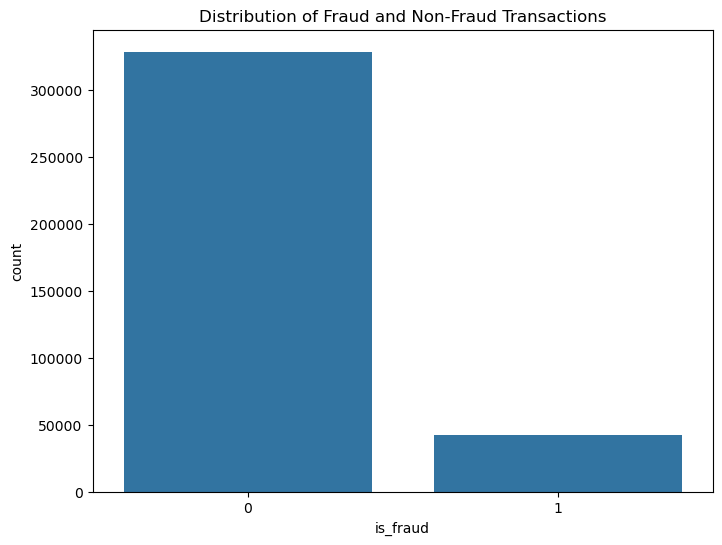

In [61]:
# Analyze the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='is_fraud', data=train_df)
plt.title('Distribution of Fraud and Non-Fraud Transactions')
plt.show()


In [62]:
# Calculate the percentage of fraudulent transactions
fraud_percentage = train_df['is_fraud'].mean() * 100
print(f"Percentage of fraudulent transactions: {fraud_percentage:.2f}%")


Percentage of fraudulent transactions: 11.41%


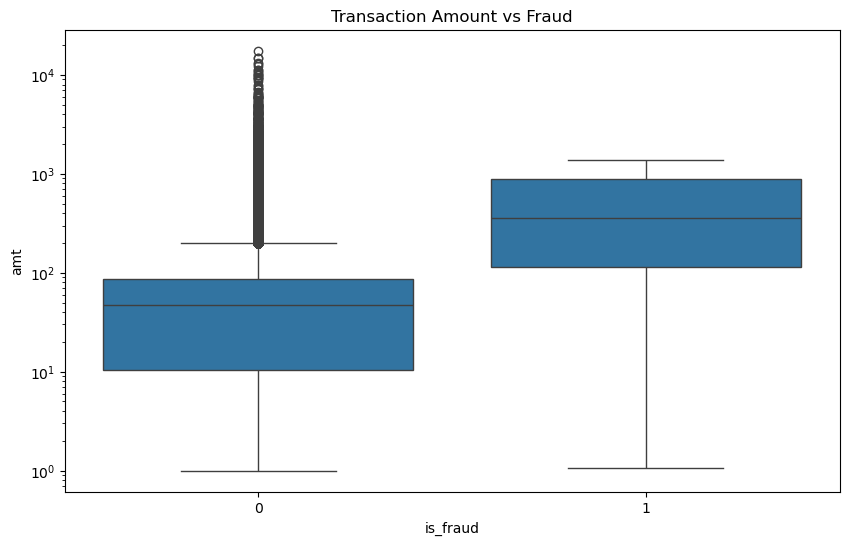

In [63]:
# Analyze the relationship between transaction amount and fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='amt', data=train_df)
plt.title('Transaction Amount vs Fraud')
plt.yscale('log')
plt.show()

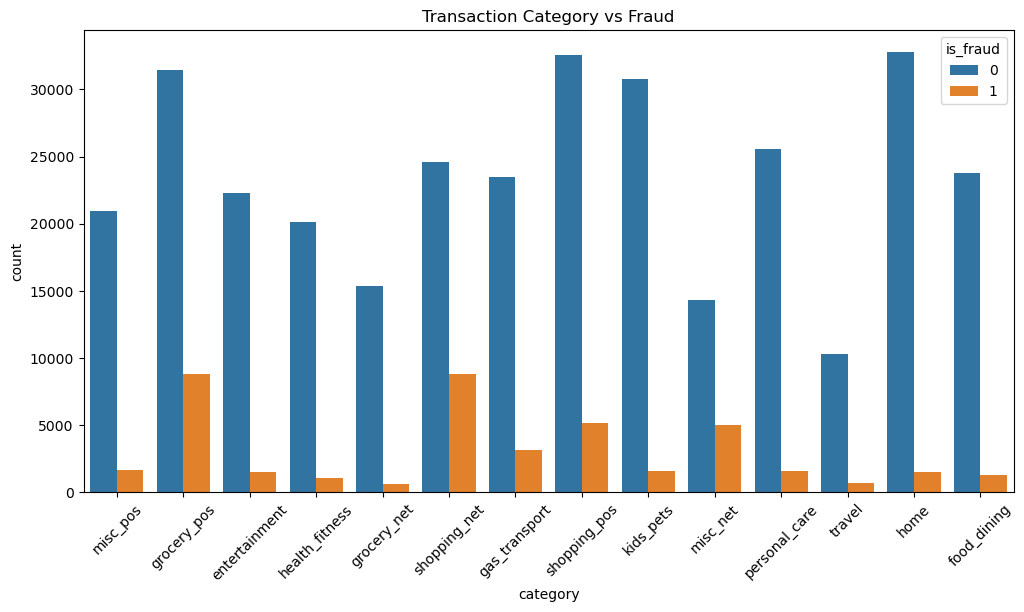

In [64]:
# Analyze the relationship between transaction category and fraud
plt.figure(figsize=(12, 6))
sns.countplot(x='category', hue='is_fraud', data=train_df)
plt.title('Transaction Category vs Fraud')
plt.xticks(rotation=45)
plt.show()


In [65]:
 # Handle infinite values by focusing only on numeric columns
def handle_infinite_values(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns  # Select only numeric columns
    df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
    return df

# Apply the function to train and test datasets
train_df = handle_infinite_values(train_df)
test_df = handle_infinite_values(test_df)

# Verify if infinite values have been removed
print("Infinite values in train_df:", train_df.select_dtypes(include=[np.number]).apply(np.isinf).values.any())
print("Infinite values in test_df:", test_df.select_dtypes(include=[np.number]).apply(np.isinf).values.any())

Infinite values in train_df: False
Infinite values in test_df: False


In [66]:

# Feature engineering with error handling
def engineer_features(df):
    try:
        df['trans_hour'] = pd.to_datetime(df['trans_time']).dt.hour
        df['time_since_last'] = df.groupby('cc_num')['unix_time'].diff()
        df['trans_freq'] = df.groupby('cc_num')['unix_time'].transform('count') / (
            df.groupby('cc_num')['unix_time'].transform('max') - 
            df.groupby('cc_num')['unix_time'].transform('min')
        )
        df['avg_amt'] = df.groupby('cc_num')['amt'].transform('mean')
        df['amt_to_avg'] = df['amt'] / df['avg_amt']
        df['distance'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)
    except Exception as e:
        print(f"Error in feature engineering: {e}")
    
    return df

train_df = engineer_features(train_df)
test_df = engineer_features(test_df)
            

/var/folders/cr/rmz3xz_s61dd6zjh0mqy_z2m0000gn/T/ipykernel_29781/882291773.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['trans_hour'] = pd.to_datetime(df['trans_time']).dt.hour
/var/folders/cr/rmz3xz_s61dd6zjh0mqy_z2m0000gn/T/ipykernel_29781/882291773.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['trans_hour'] = pd.to_datetime(df['trans_time']).dt.hour


In [67]:
# Define features for model training
categorical_features = ['category', 'gender', 'state', 'job']
numerical_features = ['amt', 'lat', 'long', 'city_pop', 'trans_hour', 'time_since_last', 'trans_freq', 'amt_to_avg', 'distance']


In [68]:
# Prepare the feature matrix and target variable
X = train_df[categorical_features + numerical_features]
y = train_df['is_fraud']

In [69]:
# Create preprocessing steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [70]:

model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', SelectFromModel(GradientBoostingClassifier(random_state=42))),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1))
])
            

In [71]:

def validate_pipeline_output(pipeline, X):
    X_transformed = pipeline.fit_transform(X)
    
    # Convert to DataFrame if necessary
    if not isinstance(X_transformed, pd.DataFrame):
        X_transformed = pd.DataFrame(X_transformed)
    
    # Validate only numeric columns
    numeric_cols = X_transformed.select_dtypes(include=[np.number])
    if numeric_cols.isnull().values.any() or np.isinf(numeric_cols).values.any():
        raise ValueError("Pipeline output contains NaN or infinity.")
    
    return X_transformed
            

# Fraud Detection Project


### This notebook demonstrates the process of fraud detection using machine learning.
It includes:
1. Data Preprocessing
2. Feature Engineering
3. Model Training and Evaluation
4. Prediction and Submission
        

In [72]:
# Handling missing values for train and test datasets
print("Handling missing values...")

# Define numeric columns dynamically to exclude 'is_fraud' from test data
numeric_cols_train = train_df.select_dtypes(include=[np.number]).columns
numeric_cols_test = test_df.select_dtypes(include=[np.number]).columns

# Impute missing values for numeric columns
train_df[numeric_cols_train] = train_df[numeric_cols_train].fillna(train_df[numeric_cols_train].median())
test_df[numeric_cols_test] = test_df[numeric_cols_test].fillna(test_df[numeric_cols_test].median())

# Handle non-numeric columns
non_numeric_cols_train = train_df.select_dtypes(exclude=[np.number]).columns
non_numeric_cols_test = test_df.select_dtypes(exclude=[np.number]).columns

# Fill non-numeric columns with "missing"
train_df[non_numeric_cols_train] = train_df[non_numeric_cols_train].fillna("missing")
test_df[non_numeric_cols_test] = test_df[non_numeric_cols_test].fillna("missing")

print("Missing values handled successfully.")

Handling missing values...
Missing values handled successfully.


In [73]:

# Train-validation split
X = train_df.drop(columns=['is_fraud', 'id'])
y = train_df['is_fraud']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")
        

Train shape: (296562, 28), Validation shape: (74141, 28)


In [74]:
# Debugging: Check non-numeric columns before assertion
non_numeric_test_cols = test_df.select_dtypes(include=['object']).columns
print("Remaining non-numeric columns in test_df:", non_numeric_test_cols)

# Drop irrelevant columns (if not already dropped)
columns_to_drop = ['trans_num', 'trans_date', 'trans_time', 'first', 'last', 'street', 'merchant']
train_df = train_df.drop(columns=columns_to_drop, errors='ignore')
test_df = test_df.drop(columns=columns_to_drop, errors='ignore')

# Process 'dob' if present
if 'dob' in train_df.columns and 'dob' in test_df.columns:
    print("Processing 'dob' to convert to age...")
    for df in [train_df, test_df]:
        df['dob'] = pd.to_datetime(df['dob'], errors='coerce')  # Convert to datetime
        df['age'] = (pd.Timestamp.now() - df['dob']).dt.days // 365  # Calculate age in years
        df.drop(columns=['dob'], inplace=True)  # Drop 'dob' column
else:
    print("'dob' column not found. Skipping age processing.")

# Handle the 'city' column
if 'city' in train_df.columns and 'city' in test_df.columns:
    print("Processing 'city' column...")
    combined_cities = pd.concat([train_df['city'], test_df['city']], axis=0).astype(str).unique()
    city_encoder = LabelEncoder()
    city_encoder.fit(combined_cities)
    
    train_df['city'] = city_encoder.transform(train_df['city'].astype(str))
    test_df['city'] = city_encoder.transform(test_df['city'].astype(str))
else:
    print("'city' column not found. Skipping city encoding.")

# Encode other categorical columns
categorical_cols = train_df.select_dtypes(include=['object']).columns

label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    # Fit on the union of unique values from both train and test
    combined_values = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    label_encoders[col].fit(combined_values)

    # Transform train and test datasets
    train_df[col] = label_encoders[col].transform(train_df[col].astype(str))
    test_df[col] = label_encoders[col].transform(test_df[col].astype(str))

# Ensure no non-numeric columns remain
non_numeric_test_cols = test_df.select_dtypes(include=['object']).columns
if not non_numeric_test_cols.empty:
    raise ValueError(f"Non-numeric columns still present in test_df after encoding: {non_numeric_test_cols}")

print("Categorical columns encoded successfully.")

# Check if all features are numeric before training
print(train_df.dtypes)

# Define feature matrix and target variable
X_train = train_df.drop(columns=['is_fraud'], errors='ignore')
y_train = train_df['is_fraud']

X_test = test_df  # Ensure this matches the columns of X_train

Remaining non-numeric columns in test_df: Index(['trans_num', 'trans_date', 'trans_time', 'category', 'first', 'last',
       'gender', 'street', 'city', 'state', 'job', 'dob', 'merchant'],
      dtype='object')
Processing 'dob' to convert to age...
Processing 'city' column...
Categorical columns encoded successfully.
id                   int64
unix_time            int64
category             int64
amt                float64
cc_num               int64
gender               int64
city                 int64
state                int64
zip                  int64
lat                float64
long               float64
city_pop             int64
job                  int64
merch_lat          float64
merch_long         float64
is_fraud             int64
trans_hour           int32
time_since_last    float64
trans_freq         float64
avg_amt            float64
amt_to_avg         float64
distance           float64
age                  int64
dtype: object


In [75]:
# Align test_features with X_train
test_features = test_df.copy()  # Define test_features based on the processed test_df

# Ensure test_features has the same columns as X_train
missing_in_test = set(X_train.columns) - set(test_features.columns)
for col in missing_in_test:
    print(f"Adding missing column '{col}' to test_features with default value 0.")
    test_features[col] = 0

extra_in_test = set(test_features.columns) - set(X_train.columns)
if extra_in_test:
    print(f"Removing extra columns from test_features: {extra_in_test}")
    test_features = test_features.drop(columns=list(extra_in_test))

# Ensure columns are in the same order as X_train
test_features = test_features[X_train.columns]


### Feature Importance
Analyzing feature importance for better interpretability of the model.
        

In [76]:
# Ensure model is fitted
if hasattr(model, "booster_"):  # Check if model is LGBMClassifier
    # Plot feature importance using the model directly
    lgb.plot_importance(model, max_num_features=20, importance_type='gain')
    plt.title('Top 20 Feature Importances')
    plt.show()

    # Access Booster object
    booster = model.booster_
    lgb.plot_importance(booster, max_num_features=20, importance_type='gain')
    plt.title('Top 20 Feature Importances (Booster)')
    plt.show()
else:
    print("The model is not a LightGBM instance or it has not been fitted.")

The model is not a LightGBM instance or it has not been fitted.


### Fix: Handling Missing and Invalid Data

In [77]:

# Replace infinite values with NaN and handle missing values
print("Replacing inf/-inf with NaN and imputing missing values...")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

train_df.fillna(train_df.median(), inplace=True)
test_df.fillna(test_df.median(), inplace=True)

print("Missing and invalid values handled.")
        

Replacing inf/-inf with NaN and imputing missing values...
Missing and invalid values handled.


In [78]:
# Replace infinite values with NaN
test_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values with the median of each column
test_features.fillna(test_features.median(), inplace=True)

# Check if all problematic values are handled
if test_features.isnull().any().any():
    raise ValueError("test_features still contains NaN values after imputation.")

# Optionally, clip large values (e.g., cap at the 99th percentile)
clip_threshold = test_features.quantile(0.99)
test_features = test_features.clip(upper=clip_threshold, axis=1)

print("Test features cleaned successfully.")

Test features cleaned successfully.


### Debugging Preprocessing Steps

In [79]:
# Check for infinity or extremely large values in X_train and X_test
def preprocess_for_large_values(X):
    # Replace infinity values with NaN
    X.replace([float('inf'), -float('inf')], np.nan, inplace=True)

    # Replace NaN with column means
    for col in X.columns:
        if X[col].isnull().any():
            X[col].fillna(X[col].mean(), inplace=True)
    
    # Cap extremely large values if needed (optional)
    max_value = 1e10  # Adjust threshold as needed
    X = X.clip(upper=max_value)
    return X

# Preprocess training and test datasets
print("Preprocessing for large/infinite values...")
X_train = preprocess_for_large_values(X_train)
X_test = preprocess_for_large_values(X_test)

print("Preprocessing complete.")

Preprocessing for large/infinite values...
Preprocessing complete.


/var/folders/cr/rmz3xz_s61dd6zjh0mqy_z2m0000gn/T/ipykernel_29781/2638875707.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].mean(), inplace=True)


In [80]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Define preprocessors
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Use median for numerical columns
    ('scaler', StandardScaler())                   # Scale numerical columns
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Fill missing categories
    ('onehot', OneHotEncoder(handle_unknown='ignore'))                      # Encode categorical data
])

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define the full pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the pipeline to the training data
print("Fitting the model...")
model.fit(X_train, y_train)
print("Model fitting complete.")

# Predictions
print("Making predictions on test data...")
test_predictions = model.predict(test_features)

Fitting the model...
Model fitting complete.
Making predictions on test data...


In [81]:
# Debugging: Check available columns
print("Available columns in train_df:", train_df.columns)
print("Available columns in test_df:", test_df.columns)

# Attempt to set a time column
time_column = None  # Initialize to None
possible_time_columns = ['transaction_time', 'timestamp', 'trans_date']  # Common names
for col in possible_time_columns:
    if col in train_df.columns and col in test_df.columns:
        time_column = col
        break

if time_column:
    print(f"Using '{time_column}' as the time column.")
    
    # Add time-based features
    print("Adding time-based features...")
    train_df['hour'] = pd.to_datetime(train_df[time_column]).dt.hour
    test_df['hour'] = pd.to_datetime(test_df[time_column]).dt.hour

    train_df['day_of_week'] = pd.to_datetime(train_df[time_column]).dt.dayofweek
    test_df['day_of_week'] = pd.to_datetime(test_df[time_column]).dt.dayofweek

    train_df['is_weekend'] = (train_df['day_of_week'] >= 5).astype(int)
    test_df['is_weekend'] = (test_df['day_of_week'] >= 5).astype(int)

    # Calculate time since last transaction for each user
    user_column = 'user_id'  # Adjust if necessary
    if user_column in train_df.columns:
        print("Calculating time since last transaction...")
        train_df['time_since_last'] = train_df.groupby(user_column)[time_column].diff().fillna(0)
        test_df['time_since_last'] = test_df.groupby(user_column)[time_column].diff().fillna(0)
else:
    print("No time-related column found. Skipping time-based feature engineering.")

# Add aggregated features
user_column = 'user_id'
transaction_amt_column = 'transaction_amt'
if user_column in train_df.columns and transaction_amt_column in train_df.columns:
    print("Adding aggregated features...")
    train_df['avg_transaction_amt'] = train_df.groupby(user_column)[transaction_amt_column].transform('mean')
    test_df['avg_transaction_amt'] = test_df.groupby(user_column)[transaction_amt_column].transform('mean')

    train_df['transaction_ratio'] = train_df[transaction_amt_column] / train_df['avg_transaction_amt']
    test_df['transaction_ratio'] = test_df[transaction_amt_column] / test_df['avg_transaction_amt']

print("Feature engineering complete.")

Available columns in train_df: Index(['id', 'unix_time', 'category', 'amt', 'cc_num', 'gender', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'merch_lat',
       'merch_long', 'is_fraud', 'trans_hour', 'time_since_last', 'trans_freq',
       'avg_amt', 'amt_to_avg', 'distance', 'age'],
      dtype='object')
Available columns in test_df: Index(['id', 'unix_time', 'category', 'amt', 'cc_num', 'gender', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'merch_lat',
       'merch_long', 'trans_hour', 'time_since_last', 'trans_freq', 'avg_amt',
       'amt_to_avg', 'distance', 'age'],
      dtype='object')
No time-related column found. Skipping time-based feature engineering.
Feature engineering complete.


In [82]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [83]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm.callback import early_stopping, log_evaluation

# Split training data for hyperparameter optimization
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the Optuna objective function
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'objective': 'binary',
        'metric': 'auc',
        'random_state': 42
    }

    # Create LightGBM dataset
    train_data = lgb.Dataset(X_train_opt, label=y_train_opt)
    valid_data = lgb.Dataset(X_val_opt, label=y_val_opt, reference=train_data)

    # Train the model with callbacks
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, valid_data],
        callbacks=[
            early_stopping(stopping_rounds=10),  # Early stopping callback
            log_evaluation(10)                  # Log progress every 10 rounds
        ]
    )
    
    # Predict on validation set
    y_pred = model.predict(X_val_opt, num_iteration=model.best_iteration)
    return roc_auc_score(y_val_opt, y_pred)

# Optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Display the best parameters
print("Best parameters:", study.best_params)

# Train the final model with best parameters
final_model = lgb.LGBMClassifier(**study.best_params, random_state=42)
final_model.fit(X_train, y_train)

[I 2024-12-08 18:36:02,056] A new study created in memory with name: no-name-838a84c6-16f7-4a34-8f83-d0ae0e0a45da
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.995779	valid_1's auc: 0.99574
[20]	training's auc: 0.998302	valid_1's auc: 0.99801
[30]	training's auc: 0.999282	valid_1's auc: 0.998785
[40]	training's auc: 0.999685	valid_1's auc: 0.999204
[50]	training's auc: 0.999842	valid_1's auc: 0.999301
[60]	training's auc: 0.999913	valid_1's auc: 0.999368
[70]	training's auc: 0.999961	valid_1's auc: 0.999402
[80

[I 2024-12-08 18:36:06,200] Trial 0 finished with value: 0.9994453353290746 and parameters: {'num_leaves': 106, 'learning_rate': 0.15035556648028364, 'max_depth': 38, 'min_child_samples': 72, 'n_estimators': 192}. Best is trial 0 with value: 0.9994453353290746.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.992967	valid_1's auc: 0.992983
[20]	training's auc: 0.995619	valid_1's auc: 0.995647
[30]	training's auc: 0.997098	valid_1's auc: 0.996942
[40]	training's auc: 0.997795	valid_1's auc: 0.997585
[50]	training's auc: 0.998479	valid_1's auc: 0.998219
[60]	training's auc: 0.998914	valid_1's auc: 0.998497
[70]	training's auc: 0.99923	valid_1's auc: 0.99876
[80

[I 2024-12-08 18:36:14,970] Trial 1 finished with value: 0.9994747390158861 and parameters: {'num_leaves': 123, 'learning_rate': 0.060143644023999646, 'max_depth': 42, 'min_child_samples': 91, 'n_estimators': 667}. Best is trial 1 with value: 0.9994747390158861.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.995809	valid_1's auc: 0.995916
[20]	training's auc: 0.998681	valid_1's auc: 0.998277
[30]	training's auc: 0.999405	valid_1's auc: 0.99906
[40]	training's auc: 0.999698	valid_1's auc: 0.999339
[50]	training's auc: 0.999853	valid_1's auc: 0.999363
[60]	training's auc: 0.999917	valid_1's auc: 0.999413
[70]	training's auc: 0.999953	valid_1's auc: 0.999421


[I 2024-12-08 18:36:17,208] Trial 2 finished with value: 0.9994274805430269 and parameters: {'num_leaves': 72, 'learning_rate': 0.1956988701769783, 'max_depth': 16, 'min_child_samples': 48, 'n_estimators': 622}. Best is trial 1 with value: 0.9994747390158861.


Early stopping, best iteration is:
[69]	training's auc: 0.99995	valid_1's auc: 0.999427


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.968032	valid_1's auc: 0.968364
[20]	training's auc: 0.988929	valid_1's auc: 0.989179
[30]	training's auc: 0.990491	valid_1's auc: 0.990757
[40]	training's auc: 0.991662	valid_1's auc: 0.992016
[50]	training's auc: 0.992628	valid_1's auc: 0.992987
[60]	training's auc: 0.993377	valid_1's auc: 0.993672
[70]	training's auc: 0.994069	valid_1's auc: 0.994362
[

[I 2024-12-08 18:36:25,518] Trial 3 finished with value: 0.9993436261787886 and parameters: {'num_leaves': 29, 'learning_rate': 0.0383540367843551, 'max_depth': 8, 'min_child_samples': 58, 'n_estimators': 440}. Best is trial 1 with value: 0.9994747390158861.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.996809	valid_1's auc: 0.996687
[20]	training's auc: 0.998493	valid_1's auc: 0.998131
[30]	training's auc: 0.999269	valid_1's auc: 0.998781
[40]	training's auc: 0.999658	valid_1's auc: 0.999142
[50]	training's auc: 0.999837	valid_1's auc: 0.999294
[60]	training's auc: 0.999924	valid_1's auc: 0.999347
[70]	training's auc: 0.999971	valid_1's auc: 0.999354
[80]	training's auc: 0.99999	valid_1's auc: 0.999376
Early stoppi

[I 2024-12-08 18:36:28,580] Trial 4 finished with value: 0.9993829719782864 and parameters: {'num_leaves': 129, 'learning_rate': 0.16612416030670285, 'max_depth': 12, 'min_child_samples': 86, 'n_estimators': 546}. Best is trial 1 with value: 0.9994747390158861.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[I 2024-12-08 18:36:36,070] Trial 5 finished with value: 0.9992373873484625 and parameters: {'num_leaves': 107, 'learning_rate': 0.17799646340759287, 'max_depth': 3, 'min_child_samples': 57, 'n_estimators': 804}. Best is trial 1 with value: 0.9994747390158861.


Early stopping, best iteration is:
[353]	training's auc: 0.999455	valid_1's auc: 0.999237


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.995237	valid_1's auc: 0.995308
[20]	training's auc: 0.998047	valid_1's auc: 0.997903
[30]	training's auc: 0.999141	valid_1's auc: 0.998889
[40]	training's auc: 0.999601	valid_1's auc: 0.999295


[I 2024-12-08 18:36:37,572] Trial 6 finished with value: 0.999305574191444 and parameters: {'num_leaves': 57, 'learning_rate': 0.18922283951309607, 'max_depth': 23, 'min_child_samples': 60, 'n_estimators': 785}. Best is trial 1 with value: 0.9994747390158861.


[50]	training's auc: 0.999741	valid_1's auc: 0.999287
Early stopping, best iteration is:
[43]	training's auc: 0.999662	valid_1's auc: 0.999306


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.99212	valid_1's auc: 0.99198
[20]	training's auc: 0.994912	valid_1's auc: 0.994951
[30]	training's auc: 0.996285	valid_1's auc: 0.996365
[40]	training's auc: 0.997341	valid_1's auc: 0.997203
[50]	training's auc: 0.998013	valid_1's auc: 0.997761
[60]	training's auc: 0.998631	valid_1's auc: 0.998335
[70]	training's auc: 0.998959	valid_1's auc: 0.998572
[80

[I 2024-12-08 18:36:42,269] Trial 7 finished with value: 0.9993582085385082 and parameters: {'num_leaves': 112, 'learning_rate': 0.05262472270789838, 'max_depth': 39, 'min_child_samples': 64, 'n_estimators': 151}. Best is trial 1 with value: 0.9994747390158861.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.970172	valid_1's auc: 0.970347
[20]	training's auc: 0.990191	valid_1's auc: 0.99015
[30]	training's auc: 0.993028	valid_1's auc: 0.993206
[40]	training's auc: 0.993805	valid_1's auc: 0.993953
[50]	training's auc: 0.994417	valid_1's auc: 0.994511
[60]	training's auc: 0.994932	valid_1's auc: 0.99507
[70]	training's auc: 0.995503	valid_1's auc: 0.99561
[80]

[I 2024-12-08 18:36:46,192] Trial 8 finished with value: 0.998547606245286 and parameters: {'num_leaves': 50, 'learning_rate': 0.029966138048393393, 'max_depth': 48, 'min_child_samples': 53, 'n_estimators': 162}. Best is trial 1 with value: 0.9994747390158861.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.995661	valid_1's auc: 0.995675
[20]	training's auc: 0.998251	valid_1's auc: 0.998056
[30]	training's auc: 0.99925	valid_1's auc: 0.998869
[40]	training's auc: 0.999629	valid_1's auc: 0.99922
[50]	training's auc: 0.999785	valid_1's auc: 0.999334
[60]	training's auc: 0.99987	valid_1's auc: 0.999399


[I 2024-12-08 18:36:48,744] Trial 9 finished with value: 0.9994040385571501 and parameters: {'num_leaves': 77, 'learning_rate': 0.17091053599227715, 'max_depth': 36, 'min_child_samples': 97, 'n_estimators': 846}. Best is trial 1 with value: 0.9994747390158861.


[70]	training's auc: 0.999919	valid_1's auc: 0.999393
Early stopping, best iteration is:
[62]	training's auc: 0.999884	valid_1's auc: 0.999404


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.995139	valid_1's auc: 0.995091
[20]	training's auc: 0.997306	valid_1's auc: 0.997208
[30]	training's auc: 0.998424	valid_1's auc: 0.998014
[40]	training's auc: 0.999138	valid_1's auc: 0.998574
[50]	training's auc: 0.999532	valid_1's auc: 0.998858
[60]	training's auc: 0.999719	valid_1's auc: 0.999062
[70]	training's auc: 0.999837	valid_1's auc: 0.999148
[

[I 2024-12-08 18:36:54,973] Trial 10 finished with value: 0.9994014420161508 and parameters: {'num_leaves': 146, 'learning_rate': 0.0851547664372585, 'max_depth': 50, 'min_child_samples': 23, 'n_estimators': 984}. Best is trial 1 with value: 0.9994747390158861.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.995462	valid_1's auc: 0.995459
[20]	training's auc: 0.997846	valid_1's auc: 0.997637
[30]	training's auc: 0.998936	valid_1's auc: 0.998643
[40]	training's auc: 0.999485	valid_1's auc: 0.999077
[50]	training's auc: 0.999735	valid_1's auc: 0.999293
[60]	training's auc: 0.99986	valid_1's auc: 0.999374
[70]	training's auc: 0.99992	valid_1's auc: 0.999386
[80

[I 2024-12-08 18:37:00,365] Trial 11 finished with value: 0.9994773266401924 and parameters: {'num_leaves': 104, 'learning_rate': 0.12882707998920118, 'max_depth': 34, 'min_child_samples': 81, 'n_estimators': 335}. Best is trial 11 with value: 0.9994773266401924.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.995885	valid_1's auc: 0.995845
[20]	training's auc: 0.99789	valid_1's auc: 0.997635
[30]	training's auc: 0.998982	valid_1's auc: 0.998474
[40]	training's auc: 0.999523	valid_1's auc: 0.998979
[50]	training's auc: 0.999741	valid_1's auc: 0.999131
[60]	training's auc: 0.999866	valid_1's auc: 0.999232
[70]	training's auc: 0.999929	valid_1's auc: 0.99929
[80

[I 2024-12-08 18:37:08,026] Trial 12 finished with value: 0.9994446523103916 and parameters: {'num_leaves': 127, 'learning_rate': 0.12376033714405126, 'max_depth': 30, 'min_child_samples': 83, 'n_estimators': 368}. Best is trial 11 with value: 0.9994773266401924.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.992537	valid_1's auc: 0.992479
[20]	training's auc: 0.995751	valid_1's auc: 0.995745
[30]	training's auc: 0.997681	valid_1's auc: 0.997494
[40]	training's auc: 0.998504	valid_1's auc: 0.998258
[50]	training's auc: 0.998995	valid_1's auc: 0.998632
[60]	training's auc: 0.999388	valid_1's auc: 0.999019
[70]	training's auc: 0.999586	valid_1's auc: 0.999157
[

[I 2024-12-08 18:37:12,492] Trial 13 finished with value: 0.9994130604671198 and parameters: {'num_leaves': 93, 'learning_rate': 0.0869013895280035, 'max_depth': 29, 'min_child_samples': 97, 'n_estimators': 326}. Best is trial 11 with value: 0.9994773266401924.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.99635	valid_1's auc: 0.995963
[20]	training's auc: 0.998203	valid_1's auc: 0.997783
[30]	training's auc: 0.999133	valid_1's auc: 0.998534
[40]	training's auc: 0.999605	valid_1's auc: 0.998992
[50]	training's auc: 0.999813	valid_1's auc: 0.999156
[60]	training's auc: 0.999915	valid_1's auc: 0.999302
[70]	training's auc: 0.99997	valid_1's auc: 0.99935
[80]

[I 2024-12-08 18:37:16,399] Trial 14 finished with value: 0.9994141768370823 and parameters: {'num_leaves': 146, 'learning_rate': 0.12632328429356918, 'max_depth': 43, 'min_child_samples': 81, 'n_estimators': 612}. Best is trial 11 with value: 0.9994773266401924.


Early stopping, best iteration is:
[98]	training's auc: 0.999999	valid_1's auc: 0.999414


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.992682	valid_1's auc: 0.992525
[20]	training's auc: 0.995715	valid_1's auc: 0.995775
[30]	training's auc: 0.997282	valid_1's auc: 0.997171
[40]	training's auc: 0.998115	valid_1's auc: 0.997846
[50]	training's auc: 0.998771	valid_1's auc: 0.998386
[60]	training's auc: 0.999162	valid_1's auc: 0.998678
[70]	training's auc: 0.999423	valid_1's auc: 0.998832
[

[I 2024-12-08 18:37:22,360] Trial 15 finished with value: 0.999379269767356 and parameters: {'num_leaves': 124, 'learning_rate': 0.0637896100746467, 'max_depth': 21, 'min_child_samples': 26, 'n_estimators': 483}. Best is trial 11 with value: 0.9994773266401924.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.994807	valid_1's auc: 0.994908
[20]	training's auc: 0.996782	valid_1's auc: 0.996832
[30]	training's auc: 0.998351	valid_1's auc: 0.998182
[40]	training's auc: 0.999046	valid_1's auc: 0.99868
[50]	training's auc: 0.999484	valid_1's auc: 0.999087
[60]	training's auc: 0.999685	valid_1's auc: 0.999235
[70]	training's auc: 0.9998	valid_1's auc: 0.99929
[80]	

[I 2024-12-08 18:37:26,118] Trial 16 finished with value: 0.9994106333432873 and parameters: {'num_leaves': 91, 'learning_rate': 0.10674550523022741, 'max_depth': 33, 'min_child_samples': 40, 'n_estimators': 671}. Best is trial 11 with value: 0.9994773266401924.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.993118	valid_1's auc: 0.993085
[20]	training's auc: 0.99629	valid_1's auc: 0.996291
[30]	training's auc: 0.997696	valid_1's auc: 0.997397
[40]	training's auc: 0.998464	valid_1's auc: 0.998125
[50]	training's auc: 0.998986	valid_1's auc: 0.998551
[60]	training's auc: 0.999355	valid_1's auc: 0.998876
[70]	training's auc: 0.999589	valid_1's auc: 0.999079
[8

[I 2024-12-08 18:37:34,817] Trial 17 finished with value: 0.9994461752815545 and parameters: {'num_leaves': 116, 'learning_rate': 0.07683712573045569, 'max_depth': 44, 'min_child_samples': 73, 'n_estimators': 300}. Best is trial 11 with value: 0.9994773266401924.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.995337	valid_1's auc: 0.99532
[20]	training's auc: 0.997631	valid_1's auc: 0.997378
[30]	training's auc: 0.998988	valid_1's auc: 0.998649
[40]	training's auc: 0.999492	valid_1's auc: 0.99905
[50]	training's auc: 0.999741	valid_1's auc: 0.999293
[60]	training's auc: 0.999855	valid_1's auc: 0.999375
[70]	training's auc: 0.999916	valid_1's auc: 0.999387
Ear

[I 2024-12-08 18:37:37,946] Trial 18 finished with value: 0.9993958993997868 and parameters: {'num_leaves': 95, 'learning_rate': 0.13983241512492292, 'max_depth': 43, 'min_child_samples': 100, 'n_estimators': 432}. Best is trial 11 with value: 0.9994773266401924.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.99124	valid_1's auc: 0.990967
[20]	training's auc: 0.992181	valid_1's auc: 0.991789
[30]	training's auc: 0.992983	valid_1's auc: 0.992732
[40]	training's auc: 0.993224	valid_1's auc: 0.992988
[50]	training's auc: 0.993594	valid_1's auc: 0.993564
[60]	training's auc: 0.994739	valid_1's auc: 0.994606
[70]	training's auc: 0.994998	valid_1's auc: 0.994873
[80]	training's auc: 0.995158	valid_1's auc: 0.995009
[90]	trainin

[I 2024-12-08 18:38:08,826] Trial 19 finished with value: 0.9993760954246508 and parameters: {'num_leaves': 138, 'learning_rate': 0.011995451707124516, 'max_depth': 25, 'min_child_samples': 91, 'n_estimators': 701}. Best is trial 11 with value: 0.9994773266401924.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.993988	valid_1's auc: 0.994084
[20]	training's auc: 0.995761	valid_1's auc: 0.995809
[30]	training's auc: 0.997764	valid_1's auc: 0.997615
[40]	training's auc: 0.998605	valid_1's auc: 0.998359
[50]	training's auc: 0.999138	valid_1's auc: 0.998885
[60]	training's auc: 0.999436	valid_1's auc: 0.999169
[70]	training's auc: 0.999602	valid_1's auc: 0.999286
[

[I 2024-12-08 18:38:12,697] Trial 20 finished with value: 0.9993616343319559 and parameters: {'num_leaves': 65, 'learning_rate': 0.10311055905324995, 'max_depth': 34, 'min_child_samples': 72, 'n_estimators': 278}. Best is trial 11 with value: 0.9994773266401924.


Early stopping, best iteration is:
[86]	training's auc: 0.99975	valid_1's auc: 0.999362


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.992606	valid_1's auc: 0.992469
[20]	training's auc: 0.995774	valid_1's auc: 0.995808
[30]	training's auc: 0.997262	valid_1's auc: 0.997132
[40]	training's auc: 0.998163	valid_1's auc: 0.997883
[50]	training's auc: 0.998787	valid_1's auc: 0.998442
[60]	training's auc: 0.999173	valid_1's auc: 0.998763
[70]	training's auc: 0.999447	valid_1's auc: 0.999003
[

[I 2024-12-08 18:38:20,457] Trial 21 finished with value: 0.9994605240239179 and parameters: {'num_leaves': 115, 'learning_rate': 0.06730623524159146, 'max_depth': 44, 'min_child_samples': 74, 'n_estimators': 237}. Best is trial 11 with value: 0.9994773266401924.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.992029	valid_1's auc: 0.991909
[20]	training's auc: 0.995238	valid_1's auc: 0.995335
[30]	training's auc: 0.996523	valid_1's auc: 0.996524
[40]	training's auc: 0.997627	valid_1's auc: 0.997373
[50]	training's auc: 0.998373	valid_1's auc: 0.998158
[60]	training's auc: 0.998768	valid_1's auc: 0.998481
[70]	training's auc: 0.999124	valid_1's auc: 0.998738
[

[I 2024-12-08 18:38:26,297] Trial 22 finished with value: 0.9994100983417076 and parameters: {'num_leaves': 103, 'learning_rate': 0.06118936251977516, 'max_depth': 40, 'min_child_samples': 79, 'n_estimators': 240}. Best is trial 11 with value: 0.9994773266401924.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.992541	valid_1's auc: 0.9926
[20]	training's auc: 0.994717	valid_1's auc: 0.99473
[30]	training's auc: 0.995931	valid_1's auc: 0.995897
[40]	training's auc: 0.997068	valid_1's auc: 0.997008
[50]	training's auc: 0.997731	valid_1's auc: 0.997494
[60]	training's auc: 0.998136	valid_1's auc: 0.997831
[70]	training's auc: 0.998569	valid_1's auc: 0.998294
[80]

[I 2024-12-08 18:38:44,164] Trial 23 finished with value: 0.999476955705764 and parameters: {'num_leaves': 123, 'learning_rate': 0.044188164234331695, 'max_depth': 46, 'min_child_samples': 67, 'n_estimators': 374}. Best is trial 11 with value: 0.9994773266401924.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.993071	valid_1's auc: 0.992832
[20]	training's auc: 0.994997	valid_1's auc: 0.994888
[30]	training's auc: 0.996051	valid_1's auc: 0.995969
[40]	training's auc: 0.996995	valid_1's auc: 0.996799
[50]	training's auc: 0.997546	valid_1's auc: 0.997392
[60]	training's auc: 0.997931	valid_1's auc: 0.997583
[70]	training's auc: 0.998439	valid_1's auc: 0.998005
[

[I 2024-12-08 18:38:56,216] Trial 24 finished with value: 0.9994644420188186 and parameters: {'num_leaves': 136, 'learning_rate': 0.04140875661419504, 'max_depth': 47, 'min_child_samples': 89, 'n_estimators': 395}. Best is trial 11 with value: 0.9994773266401924.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.989823	valid_1's auc: 0.989715
[20]	training's auc: 0.99076	valid_1's auc: 0.990575
[30]	training's auc: 0.992583	valid_1's auc: 0.992685
[40]	training's auc: 0.992927	valid_1's auc: 0.992951
[50]	training's auc: 0.993313	valid_1's auc: 0.993527
[60]	training's auc: 0.993483	valid_1's auc: 0.993665
[70]	training's auc: 0.994778	valid_1's auc: 0.994776
[80]	training's auc: 0.995379	valid_1's auc: 0.995451
[90]	trainin

[I 2024-12-08 18:38:59,311] Trial 25 finished with value: 0.9958959270914687 and parameters: {'num_leaves': 121, 'learning_rate': 0.013321320876387883, 'max_depth': 33, 'min_child_samples': 68, 'n_estimators': 100}. Best is trial 11 with value: 0.9994773266401924.


[100]	training's auc: 0.995845	valid_1's auc: 0.995896
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.995845	valid_1's auc: 0.995896


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.994398	valid_1's auc: 0.99427
[20]	training's auc: 0.996331	valid_1's auc: 0.996349
[30]	training's auc: 0.998093	valid_1's auc: 0.997801
[40]	training's auc: 0.998828	valid_1's auc: 0.998444
[50]	training's auc: 0.999383	valid_1's auc: 0.998932
[60]	training's auc: 0.999623	valid_1's auc: 0.999063
[70]	training's auc: 0.999769	valid_1's auc: 0.999248
[8

[I 2024-12-08 18:39:09,490] Trial 26 finished with value: 0.9994909941472111 and parameters: {'num_leaves': 84, 'learning_rate': 0.10168818622107392, 'max_depth': 40, 'min_child_samples': 10, 'n_estimators': 533}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.99484	valid_1's auc: 0.994994
[20]	training's auc: 0.996577	valid_1's auc: 0.996607
[30]	training's auc: 0.998269	valid_1's auc: 0.998048
[40]	training's auc: 0.99903	valid_1's auc: 0.998662
[50]	training's auc: 0.999464	valid_1's auc: 0.99903
[60]	training's auc: 0.999672	valid_1's auc: 0.999192
[70]	training's auc: 0.999806	valid_1's auc: 0.999309
[80]	training's auc: 0.999877	valid_1's auc: 0.999367
[90]	training'

[I 2024-12-08 18:39:16,217] Trial 27 finished with value: 0.9994752882841743 and parameters: {'num_leaves': 87, 'learning_rate': 0.10668565747757236, 'max_depth': 30, 'min_child_samples': 16, 'n_estimators': 519}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.995378	valid_1's auc: 0.995509
[20]	training's auc: 0.997803	valid_1's auc: 0.997713
[30]	training's auc: 0.998916	valid_1's auc: 0.998617
[40]	training's auc: 0.999501	valid_1's auc: 0.999148
[50]	training's auc: 0.999732	valid_1's auc: 0.999351
[60]	training's auc: 0.999836	valid_1's auc: 0.999368
[70]	training's auc: 0.9999	valid_1's auc: 0.999393
[80

[I 2024-12-08 18:39:19,249] Trial 28 finished with value: 0.9994367788704792 and parameters: {'num_leaves': 76, 'learning_rate': 0.15031805300697745, 'max_depth': 47, 'min_child_samples': 39, 'n_estimators': 352}. Best is trial 26 with value: 0.9994909941472111.


Early stopping, best iteration is:
[89]	training's auc: 0.999969	valid_1's auc: 0.999437


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.995363	valid_1's auc: 0.995475
[20]	training's auc: 0.997643	valid_1's auc: 0.997373
[30]	training's auc: 0.998772	valid_1's auc: 0.998407
[40]	training's auc: 0.999368	valid_1's auc: 0.998918
[50]	training's auc: 0.999656	valid_1's auc: 0.999153
[60]	training's auc: 0.999818	valid_1's auc: 0.999258
[70]	training's auc: 0.999896	valid_1's auc: 0.999317
[80]	training's auc: 0.999941	valid_1's auc: 0.999365
[90]	traini

[I 2024-12-08 18:39:23,570] Trial 29 finished with value: 0.9994245701344343 and parameters: {'num_leaves': 101, 'learning_rate': 0.11972038020061562, 'max_depth': 37, 'min_child_samples': 45, 'n_estimators': 474}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.991695	valid_1's auc: 0.99196
[20]	training's auc: 0.994445	valid_1's auc: 0.994658
[30]	training's auc: 0.996092	valid_1's auc: 0.996232
[40]	training's auc: 0.997465	valid_1's auc: 0.997382
[50]	training's auc: 0.998134	valid_1's auc: 0.997988
[60]	training's auc: 0.998846	valid_1's auc: 0.998655
[70]	training's auc: 0.999168	valid_1's auc: 0.998966
[80]	training's auc: 0.999426	valid_1's auc: 0.999155
[90]	trainin

[I 2024-12-08 18:39:27,783] Trial 30 finished with value: 0.9993621194000546 and parameters: {'num_leaves': 40, 'learning_rate': 0.09300864719554176, 'max_depth': 37, 'min_child_samples': 10, 'n_estimators': 569}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.994772	valid_1's auc: 0.994927
[20]	training's auc: 0.996448	valid_1's auc: 0.996524
[30]	training's auc: 0.998301	valid_1's auc: 0.998009
[40]	training's auc: 0.999015	valid_1's auc: 0.998541
[50]	training's auc: 0.9995	valid_1's auc: 0.998999
[60]	training's auc: 0.9997	valid_1's auc: 0.99913
[70]	training's auc: 0.999803	valid_1's auc: 0.99926
[80]	tr

[I 2024-12-08 18:39:33,665] Trial 31 finished with value: 0.9994536724370225 and parameters: {'num_leaves': 85, 'learning_rate': 0.10644710441521861, 'max_depth': 32, 'min_child_samples': 12, 'n_estimators': 531}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.995252	valid_1's auc: 0.995243
[20]	training's auc: 0.997892	valid_1's auc: 0.997618
[30]	training's auc: 0.998973	valid_1's auc: 0.998582
[40]	training's auc: 0.999485	valid_1's auc: 0.999055
[50]	training's auc: 0.999734	valid_1's auc: 0.999259
[60]	training's auc: 0.999847	valid_1's auc: 0.999296
[70]	training's auc: 0.99992	valid_1's auc: 0.999378
[8

[I 2024-12-08 18:39:37,764] Trial 32 finished with value: 0.9994363027190736 and parameters: {'num_leaves': 85, 'learning_rate': 0.13835467472883967, 'max_depth': 28, 'min_child_samples': 18, 'n_estimators': 499}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.994171	valid_1's auc: 0.994358
[20]	training's auc: 0.996473	valid_1's auc: 0.996382
[30]	training's auc: 0.998182	valid_1's auc: 0.99796
[40]	training's auc: 0.998906	valid_1's auc: 0.998609
[50]	training's auc: 0.999336	valid_1's auc: 0.998991
[60]	training's auc: 0.999603	valid_1's auc: 0.99925
[70]	training's auc: 0.999742	valid_1's auc: 0.999351
[80

[I 2024-12-08 18:39:41,275] Trial 33 finished with value: 0.9994076480344735 and parameters: {'num_leaves': 67, 'learning_rate': 0.11564095199195179, 'max_depth': 40, 'min_child_samples': 28, 'n_estimators': 418}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.99548	valid_1's auc: 0.995559
[20]	training's auc: 0.997973	valid_1's auc: 0.997737
[30]	training's auc: 0.999203	valid_1's auc: 0.998655
[40]	training's auc: 0.999615	valid_1's auc: 0.999128
[50]	training's auc: 0.999796	valid_1's auc: 0.999231
[60]	training's auc: 0.999914	valid_1's auc: 0.999276
[70]	training's auc: 0.999959	valid_1's auc: 0.999317
[8

[I 2024-12-08 18:39:47,289] Trial 34 finished with value: 0.9994372282718061 and parameters: {'num_leaves': 97, 'learning_rate': 0.14012306527494048, 'max_depth': 35, 'min_child_samples': 17, 'n_estimators': 579}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.99565	valid_1's auc: 0.995733
[20]	training's auc: 0.997924	valid_1's auc: 0.997716
[30]	training's auc: 0.999015	valid_1's auc: 0.998622
[40]	training's auc: 0.999503	valid_1's auc: 0.999076
[50]	training's auc: 0.999742	valid_1's auc: 0.999292
[60]	training's auc: 0.999867	valid_1's auc: 0.999341
[70]	training's auc: 0.999924	valid_1's auc: 0.999371
[8

[I 2024-12-08 18:39:52,794] Trial 35 finished with value: 0.9994545819397077 and parameters: {'num_leaves': 80, 'learning_rate': 0.15280019960399963, 'max_depth': 19, 'min_child_samples': 30, 'n_estimators': 451}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.994956	valid_1's auc: 0.995044
[20]	training's auc: 0.996785	valid_1's auc: 0.996807
[30]	training's auc: 0.99841	valid_1's auc: 0.9981
[40]	training's auc: 0.999149	valid_1's auc: 0.998686
[50]	training's auc: 0.99953	valid_1's auc: 0.999058
[60]	training's auc: 0.999714	valid_1's auc: 0.999191
[70]	training's auc: 0.999823	valid_1's auc: 0.999283
[80]	

[I 2024-12-08 18:39:57,142] Trial 36 finished with value: 0.9994087037709238 and parameters: {'num_leaves': 108, 'learning_rate': 0.09872744291877258, 'max_depth': 25, 'min_child_samples': 35, 'n_estimators': 527}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.992067	valid_1's auc: 0.991939
[20]	training's auc: 0.995619	valid_1's auc: 0.995697
[30]	training's auc: 0.996721	valid_1's auc: 0.996558
[40]	training's auc: 0.99819	valid_1's auc: 0.998006
[50]	training's auc: 0.998793	valid_1's auc: 0.998496
[60]	training's auc: 0.999162	valid_1's auc: 0.998805
[70]	training's auc: 0.999426	valid_1's auc: 0.99901
[80]	training's auc: 0.999619	valid_1's auc: 0.999217
[90]	training

[I 2024-12-08 18:40:04,983] Trial 37 finished with value: 0.9994885081732049 and parameters: {'num_leaves': 88, 'learning_rate': 0.07694434502355602, 'max_depth': 40, 'min_child_samples': 52, 'n_estimators': 736}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.990423	valid_1's auc: 0.99031
[20]	training's auc: 0.993619	valid_1's auc: 0.993661
[30]	training's auc: 0.995013	valid_1's auc: 0.995057
[40]	training's auc: 0.995716	valid_1's auc: 0.995683
[50]	training's auc: 0.996496	valid_1's auc: 0.996456
[60]	training's auc: 0.99739	valid_1's auc: 0.997351
[70]	training's auc: 0.997946	valid_1's auc: 0.997839
[80

[I 2024-12-08 18:40:12,069] Trial 38 finished with value: 0.9994179860483285 and parameters: {'num_leaves': 63, 'learning_rate': 0.04822886595413538, 'max_depth': 40, 'min_child_samples': 51, 'n_estimators': 730}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.991898	valid_1's auc: 0.991712
[20]	training's auc: 0.993707	valid_1's auc: 0.993732
[30]	training's auc: 0.995108	valid_1's auc: 0.995007
[40]	training's auc: 0.996214	valid_1's auc: 0.996144
[50]	training's auc: 0.996752	valid_1's auc: 0.996626
[60]	training's auc: 0.997334	valid_1's auc: 0.997106
[70]	training's auc: 0.997838	valid_1's auc: 0.997567
[80]	training's auc: 0.998058	valid_1's auc: 0.997722
[90]	traini

[I 2024-12-08 18:40:24,318] Trial 39 finished with value: 0.9994030470208893 and parameters: {'num_leaves': 135, 'learning_rate': 0.030393769493430034, 'max_depth': 50, 'min_child_samples': 62, 'n_estimators': 858}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.992783	valid_1's auc: 0.992803
[20]	training's auc: 0.996212	valid_1's auc: 0.996261
[30]	training's auc: 0.997813	valid_1's auc: 0.997579
[40]	training's auc: 0.998588	valid_1's auc: 0.998267
[50]	training's auc: 0.999069	valid_1's auc: 0.998647
[60]	training's auc: 0.999473	valid_1's auc: 0.999044
[70]	training's auc: 0.99964	valid_1's auc: 0.999157
[80]	training's auc: 0.99976	valid_1's auc: 0.999245
[90]	training

[I 2024-12-08 18:40:28,267] Trial 40 finished with value: 0.9993924147561654 and parameters: {'num_leaves': 111, 'learning_rate': 0.0810207481543091, 'max_depth': 45, 'min_child_samples': 76, 'n_estimators': 618}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.995127	valid_1's auc: 0.995209
[20]	training's auc: 0.997202	valid_1's auc: 0.997102
[30]	training's auc: 0.998505	valid_1's auc: 0.998171
[40]	training's auc: 0.999128	valid_1's auc: 0.998674
[50]	training's auc: 0.99951	valid_1's auc: 0.999098
[60]	training's auc: 0.999702	valid_1's auc: 0.999285
[70]	training's auc: 0.9998	valid_1's auc: 0.999332
[80]

[I 2024-12-08 18:40:32,176] Trial 41 finished with value: 0.999417051578903 and parameters: {'num_leaves': 88, 'learning_rate': 0.11402803543595584, 'max_depth': 41, 'min_child_samples': 67, 'n_estimators': 390}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.991427	valid_1's auc: 0.991297
[20]	training's auc: 0.994952	valid_1's auc: 0.995043
[30]	training's auc: 0.996568	valid_1's auc: 0.996408
[40]	training's auc: 0.997667	valid_1's auc: 0.997543
[50]	training's auc: 0.998303	valid_1's auc: 0.998012
[60]	training's auc: 0.99879	valid_1's auc: 0.998402
[70]	training's auc: 0.999156	valid_1's auc: 0.998739
[8

[I 2024-12-08 18:40:40,648] Trial 42 finished with value: 0.9994609966086465 and parameters: {'num_leaves': 73, 'learning_rate': 0.07048256033057086, 'max_depth': 31, 'min_child_samples': 16, 'n_estimators': 934}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.995338	valid_1's auc: 0.995414
[20]	training's auc: 0.997772	valid_1's auc: 0.997537
[30]	training's auc: 0.999039	valid_1's auc: 0.998558
[40]	training's auc: 0.999541	valid_1's auc: 0.999022
[50]	training's auc: 0.999764	valid_1's auc: 0.999135
[60]	training's auc: 0.999877	valid_1's auc: 0.999291
[70]	training's auc: 0.999937	valid_1's auc: 0.999323
[

[I 2024-12-08 18:40:45,373] Trial 43 finished with value: 0.9994264765233959 and parameters: {'num_leaves': 99, 'learning_rate': 0.13118849817539, 'max_depth': 38, 'min_child_samples': 22, 'n_estimators': 729}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.991266	valid_1's auc: 0.991016
[20]	training's auc: 0.994425	valid_1's auc: 0.994492
[30]	training's auc: 0.995349	valid_1's auc: 0.995382
[40]	training's auc: 0.996205	valid_1's auc: 0.996253
[50]	training's auc: 0.997405	valid_1's auc: 0.997237
[60]	training's auc: 0.998012	valid_1's auc: 0.99784
[70]	training's auc: 0.998457	valid_1's auc: 0.998198
[8

[I 2024-12-08 18:40:52,077] Trial 44 finished with value: 0.9994088696214133 and parameters: {'num_leaves': 81, 'learning_rate': 0.05258127530047001, 'max_depth': 27, 'min_child_samples': 85, 'n_estimators': 654}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.993112	valid_1's auc: 0.99304
[20]	training's auc: 0.995053	valid_1's auc: 0.995208
[30]	training's auc: 0.996553	valid_1's auc: 0.996625
[40]	training's auc: 0.99767	valid_1's auc: 0.997587
[50]	training's auc: 0.998503	valid_1's auc: 0.998401
[60]	training's auc: 0.998926	valid_1's auc: 0.99878
[70]	training's auc: 0.999255	valid_1's auc: 0.999066
[80]

[I 2024-12-08 18:40:55,694] Trial 45 finished with value: 0.9993949274802505 and parameters: {'num_leaves': 54, 'learning_rate': 0.0882343935762713, 'max_depth': 35, 'min_child_samples': 58, 'n_estimators': 345}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.992482	valid_1's auc: 0.992511
[20]	training's auc: 0.995785	valid_1's auc: 0.99592
[30]	training's auc: 0.99734	valid_1's auc: 0.997178
[40]	training's auc: 0.998144	valid_1's auc: 0.998005
[50]	training's auc: 0.998707	valid_1's auc: 0.998418
[60]	training's auc: 0.999104	valid_1's auc: 0.998751
[70]	training's auc: 0.999337	valid_1's auc: 0.998923
[80

[I 2024-12-08 18:41:00,682] Trial 46 finished with value: 0.999357423869525 and parameters: {'num_leaves': 105, 'learning_rate': 0.07524300926919575, 'max_depth': 12, 'min_child_samples': 65, 'n_estimators': 587}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.995137	valid_1's auc: 0.994968
[20]	training's auc: 0.997824	valid_1's auc: 0.997563
[30]	training's auc: 0.998821	valid_1's auc: 0.998524
[40]	training's auc: 0.999412	valid_1's auc: 0.998915
[50]	training's auc: 0.999687	valid_1's auc: 0.999174
[60]	training's auc: 0.999838	valid_1's auc: 0.999278
[70]	training's auc: 0.999915	valid_1's auc: 0.999349
[

[I 2024-12-08 18:41:05,325] Trial 47 finished with value: 0.999418290999229 and parameters: {'num_leaves': 119, 'learning_rate': 0.11363533175123751, 'max_depth': 46, 'min_child_samples': 47, 'n_estimators': 786}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.987442	valid_1's auc: 0.987854
[20]	training's auc: 0.991953	valid_1's auc: 0.992249
[30]	training's auc: 0.994201	valid_1's auc: 0.994459
[40]	training's auc: 0.996082	valid_1's auc: 0.996166
[50]	training's auc: 0.997297	valid_1's auc: 0.99732
[60]	training's auc: 0.997957	valid_1's auc: 0.997953
[70]	training's auc: 0.99835	valid_1's auc: 0.998309
[80]	training's auc: 0.998715	valid_1's auc: 0.998652
[90]	training

[I 2024-12-08 18:41:10,317] Trial 48 finished with value: 0.9994021268181725 and parameters: {'num_leaves': 20, 'learning_rate': 0.0966244345442103, 'max_depth': 42, 'min_child_samples': 55, 'n_estimators': 218}. Best is trial 26 with value: 0.9994909941472111.
/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 33750, number of negative: 262812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 296562, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113804 -> initscore=-2.052459
[LightGBM] [Info] Start training from score -2.052459
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.989012	valid_1's auc: 0.989047
[20]	training's auc: 0.991602	valid_1's auc: 0.991531
[30]	training's auc: 0.992388	valid_1's auc: 0.992417
[40]	training's auc: 0.994762	valid_1's auc: 0.994772
[50]	training's auc: 0.995059	valid_1's auc: 0.995133
[60]	training's auc: 0.995701	valid_1's auc: 0.995758
[70]	training's auc: 0.995963	valid_1's auc: 0.996052
[

[I 2024-12-08 18:41:20,324] Trial 49 finished with value: 0.999325890876427 and parameters: {'num_leaves': 91, 'learning_rate': 0.024942149920402754, 'max_depth': 38, 'min_child_samples': 79, 'n_estimators': 303}. Best is trial 26 with value: 0.9994909941472111.


Best parameters: {'num_leaves': 84, 'learning_rate': 0.10168818622107392, 'max_depth': 40, 'min_child_samples': 10, 'n_estimators': 533}
[LightGBM] [Info] Number of positive: 42299, number of negative: 328404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 370703, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114105 -> initscore=-2.049481
[LightGBM] [Info] Start training from score -2.049481


LGBMClassifier(learning_rate=0.10168818622107392, max_depth=40,
               min_child_samples=10, n_estimators=533, num_leaves=84,
               random_state=42)

In [84]:

# Threshold Optimization
from sklearn.metrics import precision_recall_curve

y_val_pred_prob = model.predict_proba(X_val_opt)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val_opt, y_val_pred_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold:", optimal_threshold)

# Apply this threshold to predictions
test_probabilities = model.predict_proba(test_features)[:, 1]
test_predictions = (test_probabilities >= optimal_threshold).astype(int)


Optimal Threshold: 0.55


In [85]:
# Ensure test features are preprocessed and aligned with training features
print("Aligning test features with training features...")
missing_in_test = set(X_train.columns) - set(test_features.columns)
for col in missing_in_test:
    print(f"Adding missing column '{col}' to test_features with default value 0.")
    test_features[col] = 0

extra_in_test = set(test_features.columns) - set(X_train.columns)
if extra_in_test:
    print(f"Removing extra columns from test_features: {extra_in_test}")
    test_features = test_features.drop(columns=list(extra_in_test))

# Ensure test_features columns are in the same order as X_train
test_features = test_features[X_train.columns]

# Generate predictions on the test dataset
print("Generating predictions on the test dataset...")
test_probabilities = final_model.predict_proba(test_features)[:, 1]
threshold = 0.5  # Adjust threshold if necessary
test_predictions = (test_probabilities >= threshold).astype(int)

# Create a submission DataFrame
print("Creating submission file...")
submission = pd.DataFrame({
    'id': test_df['id'],  # Ensure 'id' column exists in test_df
    'is_fraud': test_predictions
})

# Save to CSV
submission_file_name = "submission.csv"
submission.to_csv(submission_file_name, index=False)
print(f"Submission file saved as '{submission_file_name}'.")

Aligning test features with training features...
Generating predictions on the test dataset...
Creating submission file...
Submission file saved as 'submission.csv'.
